In [1]:
# generate a 1d LUT based on interpolating a transformation between two aligned frames.

import cv2
import matplotlib.pylab as plt
import numpy
import pandas
import pathlib
import skimage
import subprocess

(3956, 4300, 3)


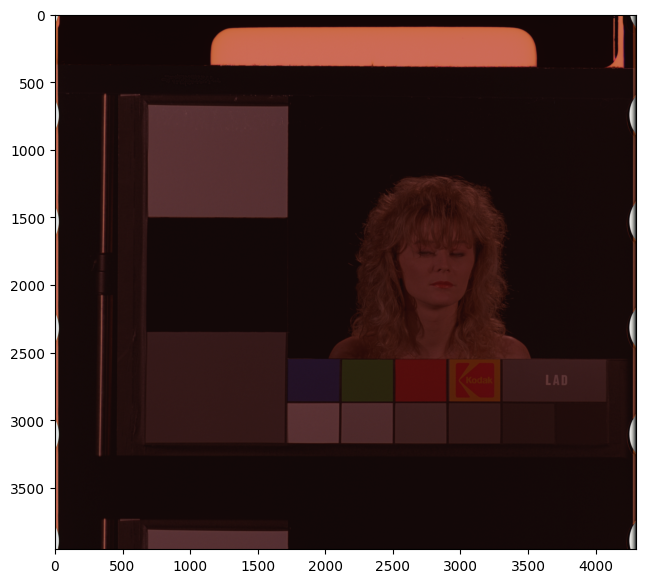

In [2]:
# source frame.

source_path = pathlib.Path.cwd() / 'source.tif'
source = cv2.cvtColor(cv2.imread(str(source_path), -1), cv2.COLOR_BGR2RGB) 

print(source.shape)
plt.figure(figsize=(7.5,7.5))
plt.imshow(skimage.img_as_float32(source))
plt.show()  

(3956, 4300, 3)


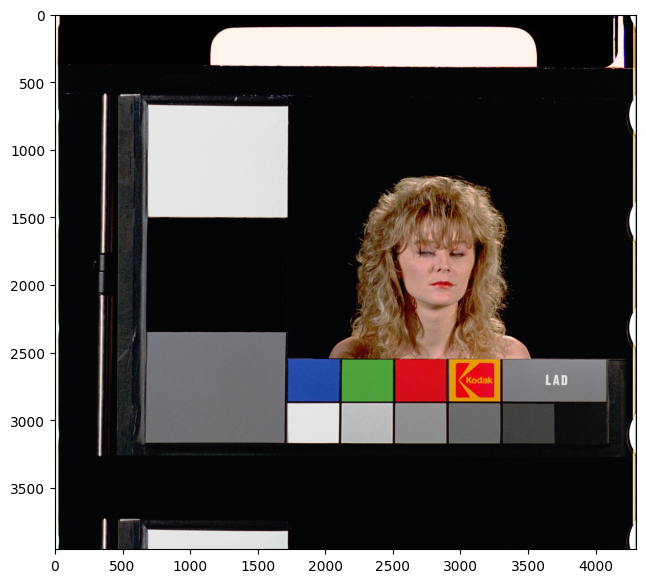

In [3]:
# target frame

target_path = pathlib.Path.cwd() / 'target.tif'
target = cv2.cvtColor(cv2.imread(str(target_path), -1), cv2.COLOR_BGR2RGB) 

print(target.shape)
plt.figure(figsize=(7.5,7.5))
plt.imshow(skimage.img_as_float32(target))
plt.show()  

In [4]:
# generate LUT.

dataframe = pandas.DataFrame({'spine': [x for x in range(0, 2**10)]})
for n, x in enumerate(['r','g','b']):
    channel_source = (source[:,:,n:n+1]/64).flatten()
    channel_target = (target[:,:,n:n+1]/64).flatten()
    channel = pandas.DataFrame({'spine': channel_source, x: channel_target})
    channel['spine'] = channel['spine'].astype('int64')
    channel[x] = channel[x].astype('int64')
    channel = channel.pivot_table(index='spine', aggfunc=lambda x: numpy.median(x)).reset_index()
    dataframe = pandas.merge(dataframe, channel, on='spine', how='left')

for n, x in enumerate(['r','g','b']):
    dataframe[x] = dataframe[x].interpolate()

lut_path = pathlib.Path.cwd() / 'lut.cube'
with open(lut_path, 'w') as lut:
    lut.write('LUT_1D_SIZE 1024\n')
    lut.write('LUT_1D_INPUT_RANGE 0.0 1.0\n')
    for x in dataframe.to_dict('records'):
        row = ' '.join(['%.6f' % (x[c]/1024) for c in ['r', 'g', 'b']])
        lut.write(row+'\n')

print(len(dataframe))
dataframe.head()

1024


,spine,r,g,b
0,0,1.0,1.0,1.0
1,1,1.0,1.0,1.0
2,2,1.0,1.0,1.0
3,3,1.0,1.0,1.0
4,4,1.0,1.0,1.0


(3956, 4300, 3)


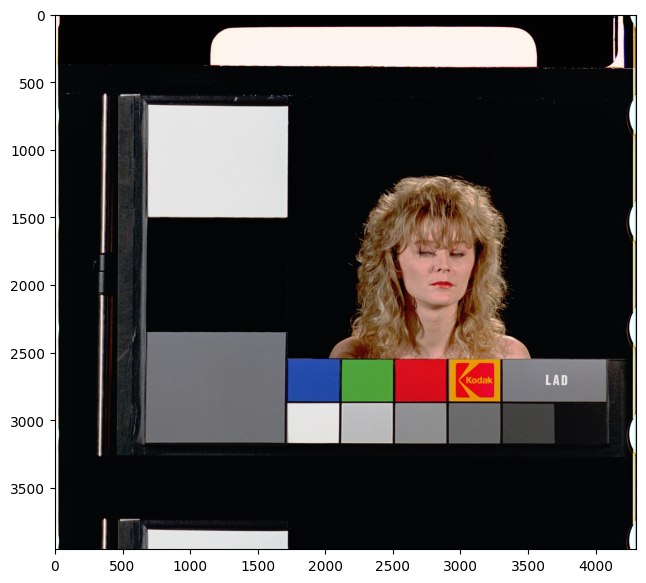

In [5]:
# apply LUT to source frame and render.

result_path = pathlib.Path.cwd() / 'result.tif'
call = ['ffmpeg', '-y', '-i', str(source_path), '-vf', f'lut1d=file={str(lut_path)}', str(result_path)]
subprocess.call(call, stderr=subprocess.DEVNULL, stdout=subprocess.DEVNULL)
result = cv2.cvtColor(cv2.imread(str(result_path), -1), cv2.COLOR_BGR2RGB) 

print(result.shape)
plt.figure(figsize=(7.5,7.5))
plt.imshow(skimage.img_as_float32(result))
plt.show()  
